In [1]:
import gym
import numpy as np
import random
import torch
import time
import matplotlib.pyplot as plt
import pandas as pd

In [18]:
og_4x4 = ['SFFF',
'FHFH',
'FFFH',
'HFFG']



In [19]:
env = gym.make('FrozenLake-v0', is_slippery=False, desc = og_4x4)


# visualize 4x4 frozen lake
env.render()


SFFF
FHFH
FFFH
HFFG


In [20]:
# Total number of States and Actions
n_states = env.observation_space.n
n_actions = env.action_space.n
n_rows = 4
n_cols = 4
print( "States = ", n_states)
print( "Actions = ", n_actions)

States =  16
Actions =  4


In [21]:
def restrict_actions(Q, n_states, n_rows):

  Q.at[n_states -1, :] = np.zeros(n_rows,)
  for i in range( 0, n_states, n_rows): 
    Q.at[i,0] = np.NaN
  for i in range( n_rows -1 , n_states, n_rows): 
    Q.at[i,2] = np.NaN
  for i in range(0, n_rows):
    Q.at[i,3] = np.NaN
  for i in range(n_states - n_rows , n_states):
    Q.at[i,1 ]= np.NaN
  
  return Q
  

In [22]:
def rewarder(new_state, reward):
  if og_4x4[rowsandcols(new_state)[0]][rowsandcols(new_state)[1]]== 'H':
    reward -= 20
  elif og_4x4[rowsandcols(new_state)[0]][rowsandcols(new_state)[1]]== 'F':
    reward -= 1 
  elif og_4x4[rowsandcols(new_state)[0]][rowsandcols(new_state)[1]]== 'S':
    reward -= 1
  else: #goal
    reward += 100

  return reward

In [23]:
def choose_action(Q, state, epsilon):
  random_for_epsilon = np.random.rand()
  if random_for_epsilon <= epsilon:
    s = Q.loc[state].notna()
    vals = s[s].index.values
    action = random.choice(vals)
  else: 
    Q.loc[state] += np.random.rand(n_actions,)/100
    action = np.argmax(Q.loc[state])
  return action

In [24]:
##assign index to each state using state-matrix

state_matrix = np.arange(0,n_states).reshape(n_rows,n_cols)
state_matrix

def rowsandcols(state):
  ''' input: state returned by env
      output: location of state as (row,col) tuple'''
  return int(np.where(state_matrix ==state)[0]), int(np.where(state_matrix ==state)[1])

In [25]:
#### Initialize Q-table

In [46]:
Q = pd.DataFrame(np.random.rand(n_states,n_actions)/1000)
Q.loc[15] = np.zeros(n_actions,)
#Q = restrict_actions(Q, n_states, n_rows)
Q

,0,1,2,3
0,0.000488,0.000138,0.000848,0.000857
1,0.000475,0.000743,0.000360,0.000519
2,0.000412,0.000367,0.000401,0.000781
3,0.000426,0.000323,0.000277,0.000050
4,0.000138,0.000864,0.000995,0.000761
5,0.000259,0.000648,0.000465,0.000953
6,0.000368,0.000654,0.000678,0.000426
7,0.000916,0.000207,0.000641,0.000108
8,0.000111,0.000299,0.000986,0.000595
9,0.000144,0.000121,0.000105,0.000988


In [47]:
epsilon = 0.8
epsilon_final = 0.1
epsilon_decay = 0.999
gamma = 0.90 # discount factor
learning_rate = 0.9 #how important is the difference between q-val from q-table and what's observed

In [48]:
num_episodes = 1000
steps_total = [] # store number of steps taken in each episode
rewards_total = [] #store reward obtained for each episode
epsilon_total = [] #store epsilon obtained at the end of each episode
terminal_state = []

In [49]:
for i_episode in range(num_episodes):
    
    # resets the environment
    state = env.reset()
    step = 0
    #reward = 0

  ## as epsilon decays with more timesteps, the prob. of selecting a random val < e decays --> more likely to exploit. 
    if epsilon > epsilon_final:
            epsilon *= epsilon_decay

    while True:
        
        step += 1
        
        random_for_epsilon = np.random.rand()
        if random_for_epsilon <= epsilon:
          action = env.action_space.sample()
        else: 
          action = np.argmax(Q.loc[state])
  
         
        ## env gives reward and next state and whether we've reached terminal state upon taking action at current state.. 
        new_state, reward , done, info = env.step(action)

        ##if you want reward penalized at for each timestep
        #reward = rewarder(new_state, reward)

        # filling the Q Table - 
        
        Q.loc[state, action] = (1- learning_rate)*Q.at[state, action] + learning_rate*(reward + gamma * np.max(Q.loc[new_state]))
        
        # Setting new state for next action
        state = new_state
        tile = og_4x4[rowsandcols(state)[0]][rowsandcols(state)[1]]
        #env.render()
        
        if done:
          #print(Q)
          
          terminal_state.append(tile)
          steps_total.append(step)
          rewards_total.append(reward)
          epsilon_total.append(epsilon)
          if i_episode % 10 == 0:
            print('Episode: {} Reward: {} Steps Taken: {} Terminal State: {}, Epsilon: {}'.format(i_episode,reward, step, tile, epsilon))
          break


        

Episode: 0 Reward: 0.0 Steps Taken: 4 Terminal State: H, Epsilon: 0.7992
Episode: 10 Reward: 0.0 Steps Taken: 2 Terminal State: H, Epsilon: 0.7912438682636309
Episode: 20 Reward: 0.0 Steps Taken: 9 Terminal State: H, Epsilon: 0.7833669407717642
Episode: 30 Reward: 0.0 Steps Taken: 3 Terminal State: H, Epsilon: 0.7755684290366581
Episode: 40 Reward: 0.0 Steps Taken: 2 Terminal State: H, Epsilon: 0.7678475524200608
Episode: 50 Reward: 0.0 Steps Taken: 5 Terminal State: H, Epsilon: 0.7602035380550674
Episode: 60 Reward: 0.0 Steps Taken: 4 Terminal State: H, Epsilon: 0.7526356207687559
Episode: 70 Reward: 0.0 Steps Taken: 3 Terminal State: H, Epsilon: 0.7451430430055925
Episode: 80 Reward: 0.0 Steps Taken: 2 Terminal State: H, Epsilon: 0.7377250547515992
Episode: 90 Reward: 0.0 Steps Taken: 2 Terminal State: H, Epsilon: 0.7303809134592769
Episode: 100 Reward: 0.0 Steps Taken: 4 Terminal State: H, Epsilon: 0.7231098839732764
Episode: 110 Reward: 0.0 Steps Taken: 8 Terminal State: H, Epsilon

In [50]:
Q

,0,1,2,3
0,0.531441,0.590490,0.590490,0.531441
1,0.531441,0.000858,0.656100,0.590490
2,0.590490,0.729000,0.589737,0.656100
3,0.656077,0.000824,0.000691,0.000050
4,0.590490,0.656100,0.000858,0.531441
5,0.000259,0.000648,0.000465,0.000953
6,0.000858,0.810000,0.000824,0.655874
7,0.000916,0.000207,0.000641,0.000108
8,0.656100,0.000894,0.729000,0.590490
9,0.656100,0.810000,0.810000,0.000858


In [51]:
%matplotlib inline

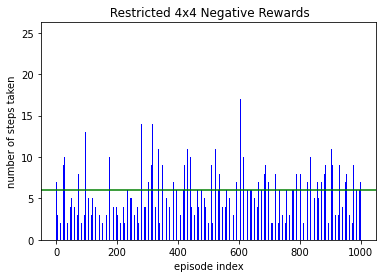

In [52]:
plt.axhline(y=6, color='green', linestyle='-')
plt.bar(np.arange(0, 1000), steps_total, 
        width = 0.4, color = 'blue')
plt.xlabel('episode index')
plt.ylabel('number of steps taken')
plt.title(' Restricted 4x4 Negative Rewards')
plt.show()

Text(0, 0.5, 'reward')

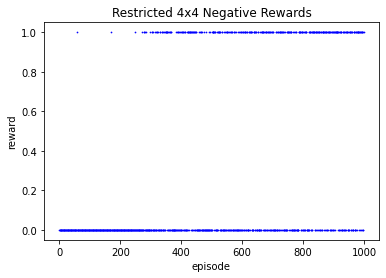

In [55]:
plt.scatter(np.arange(0, 1000), rewards_total, s = 0.5, color = 'blue')
plt.title('Restricted 4x4 Negative Rewards')
plt.xlabel('episode')
plt.ylabel('reward')

In [17]:
Q

,0,1,2,3
0,0.000724,0.000805,0.000805,0.000724
1,0.000724,0.000894,0.000724,0.000805
2,0.000805,0.000667,0.000652,0.000724
3,0.000724,0.000687,0.000652,0.000650
4,0.000805,0.000736,0.000894,0.000724
5,0.000666,0.000994,0.000744,0.000937
6,0.000363,0.000710,0.000695,0.000073
7,0.000682,0.000504,0.000499,0.000769
8,0.000735,0.000818,0.000736,0.000655
9,0.000678,0.000663,0.000726,0.000420
